# Data preaparation


In [7]:
# Summary of the Code:
'''
This code prepares and processes data from a ROOT file containing data related to 100 events.
The data is converted to numpy arrays and the dimensions/lengths are checked to ensure the
data is structured correctly. Labels are created for neighbors and all the information is saved
as an hdf5 file.
'''

'\nThis code prepares and processes data from a ROOT file containing data related to 100 events.\nThe data is converted to numpy arrays and the dimensions/lengths are checked to ensure the\ndata is structured correctly. Labels are created for neighbors and all the information is saved\nas an hdf5 file.\n'

In [8]:
import uproot # reads data from ROOT files into numpy arrays or pandas DataFrames
import numpy as np # fundamental package for numerical computing
import h5py # allows for the creation and loading of hdf5 files which are used to store large amounts of numerical data
import os # standard library for interacting with the operating system.
import matplotlib.pyplot as plt # data visualization and graphical plotting library

In [9]:
%run "GeneralFunctions.ipynb"

In [10]:
uproot.__version__

'5.3.9'

In [11]:
branches = branchesFromRootFile("MyxAODAnalysis_super3D.outputs.root")

In [12]:
branches['cluster_to_cell_indices'][0]

<Array [[23637, 23636, 23638, ..., 12212, 22613], ...] type='839 * var * int32'>

In [13]:
len(branches['cluster_to_cell_indices'][0])

839

In [14]:
len(branches['cell_cluster_index'][0])

187652

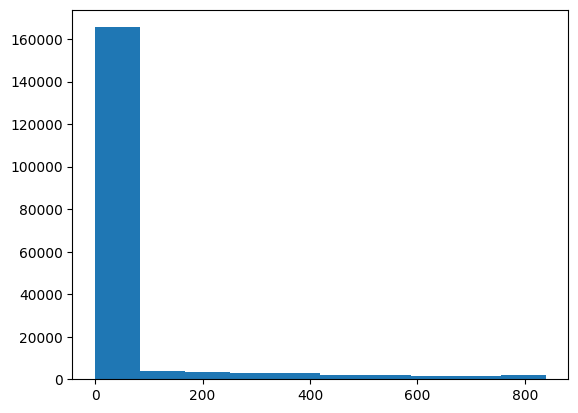

In [15]:
_=plt.hist(branches['cell_cluster_index'][0])

# Preparing data with required features for 600 events

In [16]:
cell_coordinate_x = extractData(branches, 'cell_x') #(100, 187652) 100 events and 187652 cells
cell_coordinate_y = extractData(branches, 'cell_y')
cell_coordinate_z = extractData(branches, 'cell_z')
cell_eta = extractData(branches, 'cell_eta')
cell_phi = extractData(branches, 'cell_phi')
cell_subCalo = extractData(branches, 'cell_subCalo')
cell_sampling = extractData(branches, 'cell_sampling')
cell_weight = extractData(branches, 'cell_weight')
cell_truth = extractData(branches, 'cell_truth')
cell_to_cluster_e = extractData(branches, 'cell_to_cluster_e')
cell_noiseSigma = extractData(branches, 'cell_noiseSigma')
cell_SNR = extractData(branches, 'cell_SNR')
cell_time = extractData(branches, 'cell_time')
cellsNo_cluster = branches['cellsNo_cluster'] #100 events but different number of entries per event 
# Not a np array due to irregular subarray lengths
clustersNo_event = extractData(branches, 'clustersNo_event') #(100, 1)
cell_to_cluster_index = extractData(branches, 'cell_cluster_index')
cell_e = extractData(branches, 'cell_e')
cluster_to_cell_indices = branches['cluster_to_cell_indices'] # Not a np array due to irregular subarray lengths
#100 events, but with different entries per event.
neighbor = branches['neighbor'] # Not a np array due to irregular subarray lengths
#100 events but with a repeating pattern of 
#[[63, 1, 26496, 26497, 26498, 26499, 64, 26751, 127, 26500, 65, 448], ...]...

#Creates awkward arrays for all needed variables from the branches object

In [17]:
variables = [cell_coordinate_x, cell_coordinate_y, cell_coordinate_z, cell_eta, cell_phi, cell_sampling, cell_noiseSigma, cell_e]
generalized_range = len(cell_to_cluster_index)
data = {}

_=createDataDict(generalized_range, variables, data)

In [18]:
data['data_0']
# The data dictionary has 100 keys, each with a shape of (187652, 8), indicating
# that each cell has 8 features, as noted in the for loop above.

array([[  616.83886719,    33.27997589, -3970.41845703, ...,
            6.        ,  2000.01452637,  1153.41552734],
       [  610.66046143,    93.48491669, -3970.41845703, ...,
            6.        ,  2000.01428223,  -585.24676514],
       [  598.61065674,   152.79437256, -3970.41845703, ...,
            6.        ,  2000.01452637, -2005.09155273],
       ...,
       [ 2476.01391602,  -121.63833618,  3552.        , ...,
           17.        ,   655.00445557,   318.4524231 ],
       [ 1890.02062988,   -92.85043335,  3536.        , ...,
           17.        ,  1548.81225586,  2088.82275391],
       [ 1392.52062988,   -68.40991211,  3536.        , ...,
           17.        ,   855.40997314,   474.59490967]])

In [19]:
data['data_0'].shape

(187652, 8)

In [20]:
saveDictToHDF5(data,'/storage/mxg1065/cellFeatures_100evs.hdf5')

## preparing Neighbor Pairs

In [21]:
neighbor = branches['neighbor'][0]
len(neighbor) # Number of cells

187652

In [22]:
neighbor[0] # ID of the cells neighboring each cell

<Array [63, 1, 26496, 26497, 26498, ..., 127, 26500, 65, 448] type='12 * int32'>

In [23]:
neighborPairsSet = removeBrokenCells(cell_noiseSigma, neighbor)

In [24]:
print(neighborPairsSet[:5])
print("Length of Neighbor Pairs Set:",len(neighborPairsSet))

[(0, np.int32(63)), (0, np.int32(1)), (0, np.int32(26496)), (0, np.int32(26497)), (0, np.int32(26498))]
Length of Neighbor Pairs Set: 2500484


In [25]:
#remove list_of_tuples = [(3, 1), (1, 3), (2, 4), (4, 2), (5, 6)]
neighborPairsUnique = removePermutationVariants(neighborPairsSet)

In [26]:
len(neighborPairsUnique)

1250242

In [27]:
neighborPairsUniqueSorted = sorted(neighborPairsUnique, key=lambda x: x[0])
# Sorts the unique neighbor pairs by the first element of each tuple

In [28]:
neighborPairsUniqueSorted[:5]

[(0, np.int32(26751)),
 (0, np.int32(1)),
 (0, np.int32(127)),
 (0, np.int32(26497)),
 (0, np.int32(63))]

In [29]:
writeH5File('/storage/mxg1065/neighborPairsUniqueSorted.hdf5', 'neighbor_pair', neighborPairsUniqueSorted)

## Loading neighbor cell pairs

In [30]:
neighborPairsUniqueSorted = readH5File('/storage/mxg1065/neighborPairsUniqueSorted.hdf5', 'neighbor_pair')

In [31]:
neighborPairsUniqueSorted.shape

(1250242, 2)

## Creating Labels for neighbor_pairs

In [32]:
cell_to_cluster_index.shape

(100, 187652)

In [33]:
pairsMapping = neighborPairsMapping(0,2,3,4)

In [34]:
true_neighbor_cluster = labelNeighborPairs(len(cell_to_cluster_index), cell_to_cluster_index, neighborPairsUniqueSorted, pairsMapping)

In [35]:
print(true_neighbor_cluster)
print(true_neighbor_cluster.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 3 2 0]
 [1 1 1 ... 0 0 0]]
(100, 1250242)


In [36]:
writeH5File('/storage/mxg1065/neighborLabels100Events.hdf5', 'neighborLabels100Events', true_neighbor_cluster)